<a href="https://colab.research.google.com/github/ranjeev3000/TensorFlow-Handson/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Transfer Learning with Tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and lern patterns for our own problems.'


There are two main benefits:
1. Can leverage an exisinsting neural networks architecture proven to work on problems similar to own.
2, Can leverage a working neural networks ehich has already learn patterns on similar data to our own, then we can adopt those patterns to our own.


In [1]:
# Are we using a GPU?
!nvidia-smi

Fri Feb  3 18:50:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the Data

In [2]:
# Get Data (10% of food classes from Food-101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-03 18:50:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2023-02-03 18:50:14 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load our images in batches:

In [4]:
# Setup data inpiuts
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224,224)
BATCH_SIZE = 32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


print("Training_Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode='categorical')
 
print("Testing_Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMG_SHAPE,
                                              batch_size = BATCH_SIZE,
                                             class_mode="categorical")

Training_Images
Found 750 images belonging to 10 classes.
Testing_Images
Found 2500 images belonging to 10 classes.


## Setting up Callbacks (things to learn whilst our model learns)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model Checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard Callback (functionalized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name+ "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using tensorFlow hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process except majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained model on: https://tfhub.dev/

Browsing the TensorFlow Hub Page and sorting for image classification, we found following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub Url and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in a output layer, should be equal to number of target classes, default 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes output neurons. 
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable =False,  # Freeze the already learned patterns
                                           name="feature_extraction_layer",
                                          input_shape = IMG_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax", name="output_layer")
  ])

  return model


### Creating and testing resNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])


In [11]:
# Let's fit our Resnet model to the Data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch= len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                      experiment_name="resnet50v2"
                                                                      )])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230203-185027
Epoch 1/5
24/24 [==============================] - 32s 743ms/step - loss: 1.9432 - accuracy: 0.3600 - val_loss: 1.2289 - val_accuracy: 0.6072
Epoch 2/5
24/24 [==============================] - 16s 675ms/step - loss: 0.9342 - accuracy: 0.7160 - val_loss: 0.8717 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 16s 707ms/step - loss: 0.6282 - accuracy: 0.8200 - val_loss: 0.7389 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.4866 - accuracy: 0.8600 - val_loss: 0.6857 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.3879 - accuracy: 0.9027 - val_loss: 0.6921 - val_accuracy: 0.7760


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


wow...

That is incredible !!!!

Our Transfer learning feature extractor model outperforms all of the previou models we built by hand... (substantially) and in a quicker training time and with only 10% of the training examples.

In [13]:
# Let's create a function to plot our loss curve
# Tidbit: you could put a function like this into a script called "helper.py" and import it hen you need it....
import matplotlib.pyplot as plt

# Plot our validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

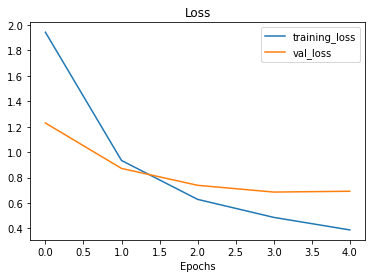

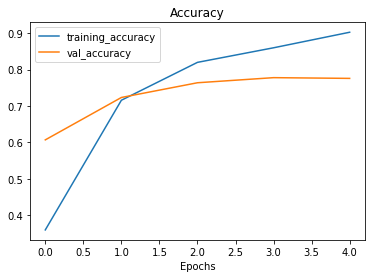

In [14]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [15]:
# Create EfficientNetB0 Feature Extractor Model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps = len(test_data),
                                              callbacks= create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")
                                              )

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230203-185230
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9026 - accuracy: 0.4160 - val_loss: 1.3138 - val_accuracy: 0.7308
Epoch 2/5
24/24 [==============================] - 17s 740ms/step - loss: 1.0771 - accuracy: 0.7667 - val_loss: 0.8681 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7631 - accuracy: 0.8307 - val_loss: 0.6974 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6123 - accuracy: 0.8560 - val_loss: 0.6134 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 15s 645ms/step - loss: 0.5146 - accuracy: 0.8853 - val_loss: 0.5566 - val_accuracy: 0.8616


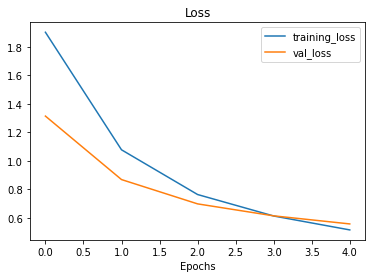

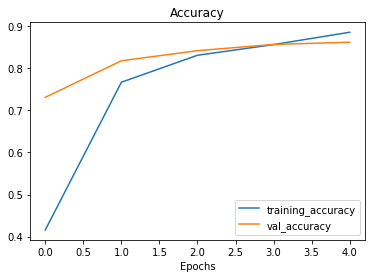

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

*  **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using Imagenet model on 1000 ImageNet classes, none of your own).
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers ( including new output layers)

## Comparing our models result using TensorBoard

> **Note:** When you upload something to TensorBoard Dev, your experiments are public. So, if you're running private experiments. things you don't want others to see. Do not upload them to TensorBoaerd dev.

In [ ]:
# Upload TensorBoard Dev Records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. ResNet50V2" \
 --description "Comparing two different TF hub feature extraction model architectures usiing 10% of the training data" \
 --one_shot

Our TensorBoard Experiments are uploaded publically here: https://tensorboard.dev/experiment/0XE76odJS0WXNinU1yztgw/

In [20]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/0XE76odJS0WXNinU1yztgw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF hub feature extraction model architectures usiing 10% of the training data
	Id                   0XE76odJS0WXNinU1yztgw
	Created              2023-02-03 18:59:16 (5 minutes ago)
	Updated              2023-02-03 18:59:18 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794895
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id 0XE76odJS0WXNinU1yztgw

In [ ]:
# Confirm the deletion by rechecking what you have 
!tensorboard dev list